BELOW COMMUNITY DETECTION CODE WRITTEN BY PRATHAM

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Read csv files
members = pd.read_csv('/content/drive/MyDrive/SNA /datasets-1/members.csv', index_col='member_id')
groups = pd.read_csv('/content/drive/MyDrive/SNA /datasets-1/groups.csv', index_col='group_id')
events = pd.read_csv('/content/drive/MyDrive/SNA /datasets-1/events.csv', index_col='event_id')
meta_data = pd.read_csv('/content/drive/MyDrive/SNA /Dataset/meta-groups.csv')
members_df = pd.read_csv('/content/drive/MyDrive/SNA /datasets-1/member-to-group-edges.csv')
rsvps = pd.read_csv('/content/drive/MyDrive/SNA /Dataset/rsvps.csv')


In [ ]:
edges = pd.read_csv('/content/drive/MyDrive/SNA /Dataset/member-edges.csv')
g = nx.from_pandas_edgelist(edges, 'member1', 'member2', 'weight')
print('There are', len(g.nodes), 'nodes and', len(g.edges), 'edges.')

There are 11372 nodes and 1176368 edges.


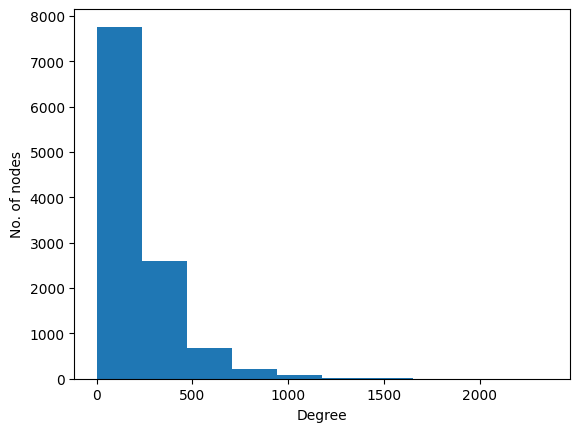

In [ ]:
#Degree distribution of member-member graph
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.xlabel("Degree")
    plt.ylabel("No. of nodes")
    plt.show()
    
plot_degree_dist(g)

In [ ]:
# Get NashJs events
nashjs_id = 10016242
nashjs_event_ids = events.loc[events.group_urlname == 'nashjs'].index.tolist()

# Get list of unique member_ids attending a Nashjs event
nashjs_rsvps = rsvps.loc[rsvps.event_id.isin(nashjs_event_ids)]
nashjs_member_ids = nashjs_rsvps['member_id'].unique().tolist()

# nashjs_member_ids = rsvps.loc[rsvps.event_id.isin(nashjs_events), 'member_id'].unique()

print('There are {} NashJs events.'.format(len(nashjs_event_ids)))
print('There are {} NashJS attendees.'.format(len(nashjs_member_ids)))


There are 23 NashJs events.
There are 760 NashJS attendees.


In [ ]:
#Graph of member-events data
g = nx.from_pandas_edgelist(nashjs_rsvps, 
                             source='member_id', 
                             target='event_id')

# Add "Node Type" attribute 
node_type_dict = {n: ('member' if n in nashjs_member_ids else 'event') 
                        for n in g.nodes}
nx.set_node_attributes(g, node_type_dict, 'node_type')

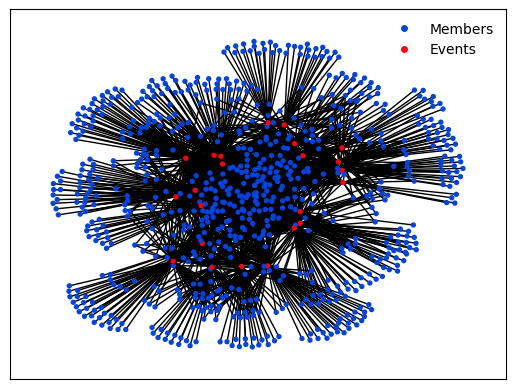

In [ ]:
pos = nx.spring_layout(g)
colors = ['xkcd:blue' if g.nodes[n]['node_type'] == 'member'
              else 'xkcd:bright red' for n in g.nodes]
nx.draw_networkx(g, pos, node_color=colors, node_size=8,
                       with_labels=False)

# Draw a legend
handles = [plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="xkcd:blue"), 
           plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="xkcd:bright red")]
plt.legend(handles, ['Members', 'Events'], frameon=False)
# ax = plt.gca()
# ax.set_aspect(1)
# ax.axis('off')

plt.show()

In [ ]:
#Getting member-member graph from member-event graph
member_nodes, event_nodes = nx.bipartite.sets(g)
# print('There are {} members and {} events.'.format(len(member_nodes), len(event_nodes)))

In [ ]:
# For member-member graph, nodes represent member_id and edges represent shared events between 2 members
gm = nx.bipartite.weighted_projected_graph(g,member_nodes,False)    

ge = nx.bipartite.weighted_projected_graph(g, event_nodes, False)
# pos = nx.spring_layout(ge)
# nx.draw_networkx(ge, pos, node_size=8,
#                        with_labels=False)
# plt.show()

In [ ]:
#Find no of events attended by a particular member and degree of that member and betweeness centrality

# Initialize df
df_members = pd.DataFrame(index=gm.nodes)
df_members['num_events'] = pd.Series(dict(g.degree))   
df_members['degree'] = pd.Series(dict(gm.degree))
df_members['centrality'] = pd.Series(nx.betweenness_centrality(gm))

df_members.head()

,num_events,degree,centrality
509953,4,254,0.001167
202010629,1,89,0.000000
221577224,1,140,0.000000
236163083,2,181,0.000245
216782860,2,198,0.000345


In [ ]:
#Find which members have highest degree and centrality
famous_members = df_members.sort_values(by='centrality', ascending=False).head().join(members)
famous_members[['name', 'city', 'num_events', 'degree', 'centrality']]

,name,city,num_events,degree,centrality
8111102,William Golden,Nashville,23,759,0.039739
26576702,Ryan Macy,Nashville,23,759,0.039739
177418312,Justin M,Hermitage,20,720,0.033753
71851852,Rick Murdock,Franklin,17,677,0.028142
85557392,Michael Knell,Nashville,17,660,0.025074


In [ ]:
# After this, we can compare and analyse about NashJs with whole meetup network i.e.
# In whole meetup,which members are of NashJS grps having highest betweenness centrality
#  We can find that top members have participated in which other grps events apart from nashjs grp events
# We can find details of top members of whole nashville meetup network
# We can find which grps have highest centrality in whole meetup network
# We can find and plot most clustered grps in this network

In [ ]:
#total members and events
print("There are {} unique members and {} unique events.".format(len(rsvps.member_id.unique()), 
                                                                 len(rsvps.event_id.unique())))

There are 24631 unique members and 19031 unique events.


In [ ]:
# Mapping of members with events and groups
member_events = {}
for index, row in rsvps.iterrows():
    event_id = row['event_id']
    group_id = row['group_id']
    member = row['member_id']
    if member not in member_events:
      member_events[member] = []
    member_events[member].append((event_id, group_id))

# Mapping event_id and member_ids of that event 
event_members = {}
for index, row in rsvps.iterrows():
    event_id = row['event_id']
    member = row['member_id']
    if event_id not in event_members:
      event_members[event_id] = []
    event_members[event_id].append(member)

# Mapping of group_id to member_id
group_members = {}
for index, row in members_df.iterrows():
    group_id = row['group_id']
    member_id = row['member_id']
    if group_id not in group_members:
      group_members[group_id] = []
    group_members[group_id].append(member_id)

# Determine how many members of each group participated in each event
event_participation = {}
for event_id, group_id in rsvps[['event_id', 'group_id']].itertuples(index=False):
    own_group_count = 0
    other_group_count = 0
    for member in event_members[event_id]:
        if member in group_members[group_id]:
            own_group_count += 1
        else:
            other_group_count += 1
    event_participation[event_id] = {'own_group_count': own_group_count, 'other_group_count': other_group_count}

# Print the results
for event_id, participation in event_participation.items():
    print(f"Event {event_id}: {participation['own_group_count']} members of own group participated and {participation['other_group_count']} members of other groups participated.")




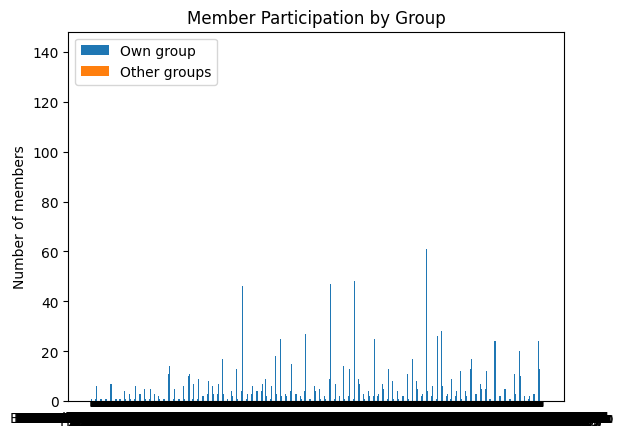

In [ ]:
x_labels = [f"Event {event_id}" for event_id in event_participation.keys()]
own_group_counts = [participation['own_group_count'] for participation in event_participation.values()]
other_group_counts = [participation['other_group_count'] for participation in event_participation.values()]

x = range(len(x_labels))
width = 0.4

fig, ax = plt.subplots()
own_group_bars = ax.bar(x, own_group_counts, width, label='Own group')
other_group_bars = ax.bar([i + width for i in x], other_group_counts, width, label='Other groups')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(x_labels)
ax.set_ylabel('Number of members')
ax.set_title('Member Participation by Group')
ax.legend()

plt.show()

In [ ]:
# Counting members who have attended 1 event and members who attended more than 1 event
# Members having membership have been attended more than 1 event
rsvps_group = (rsvps.groupby(['member_id', 'group_id']).size()
                   .reset_index().rename(columns={0: 'weight'}) )
rsvps_group['membership'] = rsvps_group.weight > 1

n_filt, n_keep = rsvps_group.membership.value_counts().values
print('{} members had only attended one event in a group and \n{} members had attended more than one  events.'.format(n_filt, n_keep))

# rsvps_group.head()

27588 members had only attended one event in a group and 
17995 members had attended more than one  events.


In [ ]:
# Graph of members who have attended more than 1 events
g = nx.from_pandas_edgelist(rsvps_group.loc[rsvps_group.membership==True], 
                             'member_id', 'group_id', ['weight'])
node_type_dict = {n: ('member' if n in members.index else 'group') 
                        for n in g.nodes}
nx.set_node_attributes(g, node_type_dict, 'node_type')
# pos = nx.spring_layout(g)
# nx.draw_networkx(g, pos,node_size=8,
#                        with_labels=False)

# plt.show()


In [ ]:
components = nx.connected_components(g)
components = sorted(list(components), key=len)
component_lengths = [len(x) for x in components]
g = nx.subgraph(g, components[-1])

In [ ]:
# Dividing members and groups
member_nodes, group_nodes = nx.bipartite.sets(g)
gm = nx.bipartite.weighted_projected_graph(g, member_nodes, ratio=False)
# pos = nx.spring_layout(gm)
# nx.draw_networkx(gm, pos, node_size=8,
#                        with_labels=False)
# plt.show()

In [ ]:
def get_graph_measures(centrality_subset_ratio=0.25):
    # Initialize our dataframe
    df = pd.DataFrame(index=gm.nodes)
    df['in_nashjs'] = [True if n in nashjs_member_ids 
                                   else False for n in gm.nodes]

    # Add in "group" degree from the original graph
    df['num_groups'] = pd.Series(dict(nx.degree(g, member_nodes)))

    # Get member-graph measures
    df['degree'] = pd.Series(dict(nx.degree(gm)))
    
    # Centrality, especially betweenness centrality, is an intensive calculation
    subset_size = np.floor(centrality_subset_ratio * len(g.nodes)).astype(int)
    centrality = nx.betweenness_centrality(gm, k=subset_size, weight='weight')
    df['centrality'] = pd.Series(centrality)

    # Save the member information to csv
    df.to_csv('/content/drive/MyDrive/SNA /datasets-1/nashville_graph_data.csv', encoding='utf8')
    
    return df

overwrite = False
if overwrite == True:
    df_members = get_graph_measures(0.25)
if overwrite == False:
    df_members = pd.read_csv('/content/drive/MyDrive/SNA /datasets-1/nashville_graph_data.csv', index_col='member_id')

In [ ]:
#Details of members participated in events of which groups
def member_details(member_id,  num_groups=5):
    gdict = {targ: attr['weight'] for src,targ,attr in g.edges(member_id, data=True)}
    gdf = (pd.DataFrame.from_dict(gdict, orient='index')
               .rename(columns={0: 'events_attended'})
               .join(groups).sort_values(by='events_attended', ascending=False) )

    gdf[['group_name', 'events_attended']]
    
    report_str = '{} ({}) is a member of {} groups.\n'.format(members.loc[member_id, 'name'], member_id, gdf.shape[0])
    report_str += 'Topmost events attended are:\n'
    max_groups = num_groups if (gdf.shape[0] >= num_groups) else gdf.shape[0]
    for ind, s in gdf.iloc[0:max_groups].iterrows():
        report_str += '- {}: {}\n'.format(s.group_name, s.events_attended)
        
    print(report_str)

In [ ]:
nashville_famous_members = (df_members.sort_values(by='centrality', ascending=False)
                    .join(members['name']).iloc[0:5]
                    [['name', 'degree', 'centrality']] )
nashville_famous_members

,name,degree,centrality
member_id,,,
3949436,Pablo,1377,0.019059
8539046,Shalini,1911,0.018181
5900662,Matt Kenigson,1811,0.016951
197928971,Ted,1620,0.015200
175300482,Rav,1556,0.014787


In [ ]:
member_details(3949436, 8)

Pablo (3949436) is a member of 16 groups.
Topmost events attended are:
- Eat Love Nash: 9
- Nashvegans!: 6
- 20&UP Tennis: Nashville: 6
- Nashville Spanish Meetup: 5
- Spiritual Psychology and Consciousness Group: 5
- Nashville Pilgrimage Hiking & Walking Meetup Group: 5
- The Joy of Dining Out with Friends Meetup: 4
- Nashville Tennis Meetup: 4



BELOW COMMUNITY DETECTION CODE WRITTEN BY NEEL

Community evolution on 2015-11-01:


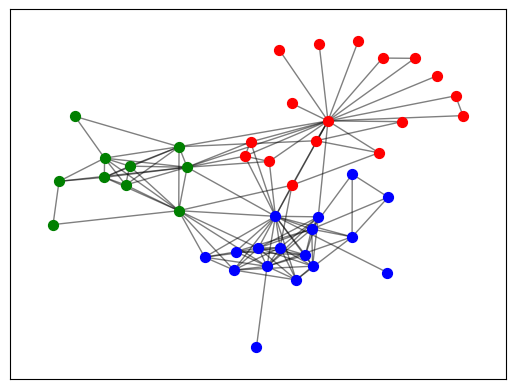

Cluster information table:


,Cluster ID,Number of Nodes,total_weight,nodes,group_names,attendance_percentages
0,1,17,57,"[20064276, 18955830, 18297014, 1505523, 981249...","[Nashville Women of a Certain Age Meetup, Eat ...","[1.1111111111111112, 0.1455604075691412, 0.303..."
1,2,10,28,"[1772099, 18714758, 18243826, 18549438, 197281...","[Nashville 80s Music & More Meetup, Nashville ...","[7.575757575757576, 1.4084507042253522, 0.1831..."
2,0,17,23,"[20135961, 18506072, 1417288, 541319, 21174496...","[20s/30s Nashville Online Dating Rebellion!, 2...","[1.1235955056179776, 1.3669821240799158, 0.581..."


Top 3 groups is respective cluster


,Cluster ID,top_groups
0,1,"[(What the Pho!,), (Wellness Nashville,), (Vol..."
1,2,"[(Stepping Out Social Dance Meetup,), (One Dha..."
2,0,"[(¡Diablos Que Bailan! (Salsa Nashville),), (W..."




Community evolution on 2016-10-31:


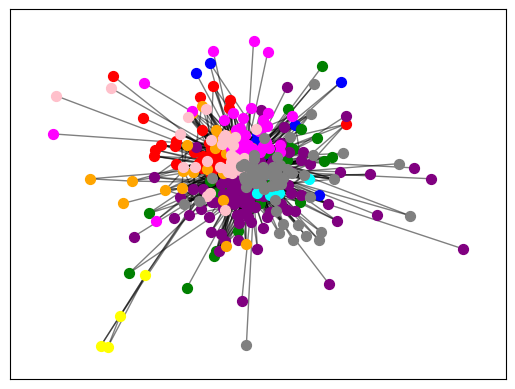

Cluster information table:


,Cluster ID,Number of Nodes,total_weight,nodes,group_names,attendance_percentages
0,0,83,13504,"[19292162, 20947040, 18850080, 6707902, 412691...","[Nashville CocoaHeads, Nashville Blockchain Me...","[78.94736842105263, 20.06269592476489, 73.4883..."
1,8,35,3146,"[535553, 18494105, 9376702, 22817838, 20186791...","[Nash.rb, The Iron Yard - Nashville, Nashville...","[81.37254901960785, 63.44605475040258, 63.4375..."
2,7,51,7334,"[19997487, 19194894, 11294262, 16487812, 19108...","[Developer Launchpad Nashville, Nashville Chri...","[58.29596412556054, 77.41935483870968, 61.6279..."
3,9,61,5790,"[1179719, 20807142, 18955830, 19828207, 135604...","[Nashvegans!, Music City Young Professionals, ...","[66.37554585152839, 19.3717277486911, 59.82532..."
4,4,119,8590,"[19728145, 18297014, 18506072, 339011, 2492573...","[Stepping Out Social Dance Meetup, Nashville C...","[49.86772486772487, 61.51515151515151, 79.2849..."
5,2,38,1795,"[18414590, 19964997, 18556100, 4705492, 182886...","[Women 'n' Wine of Nashville, Nashville's Soci...","[77.06422018348624, 43.604651162790695, 57.894..."
6,1,15,1182,"[1776274, 19416348, 1585196, 6230672, 2520612,...","[Nashville SEO & Internet Marketing, Over 1,60...","[66.50366748166259, 67.62589928057554, 58.1314..."
7,5,28,1712,"[1417288, 18549438, 1772099, 18634990, 1354051...","[The Nashville Singer, Musician and Songwriter...","[70.93023255813954, 70.76923076923077, 49.2424..."
8,6,9,1167,"[981249, 18529135, 11776502, 18256892, 2359596...","[Art of Living, Franklin AM - Networking, NASH...","[55.55555555555556, 58.536585365853654, 33.774..."
9,3,4,19,"[2486942, 1780720, 10032122, 18974119]","[Nashville Singularity Meetup, The Inter-Relig...","[100.0, 16.666666666666664, 60.0, 90.909090909..."


Top 3 groups is respective cluster


,Cluster ID,top_groups
0,0,"[(Tintri Nashville - VMaware storage,), (The N..."
1,8,"[(freeCodeCamp Nashville,), (WordPress Nashvil..."
2,7,"[(The Leadership Circle,), (Tennessee Real Est..."
3,9,"[(the New World is in Order!,), (Women's Bible..."
4,4,"[(¡Diablos Que Bailan! (Salsa Nashville),), (i..."
5,2,"[(You are a Badass!,), (Women's Business Netw..."
6,1,"[(Women, Wine, & Coloring,), (The Nashville Wr..."
7,5,[(Unity of Nashville Spirituality Meetup Group...
8,6,"[(WomanSpeak, Nashville Circles,), (Wellness N..."
9,3,"[(The Inter-Religious Conversation,), (Nashvil..."




Community evolution on 2017-10-30:


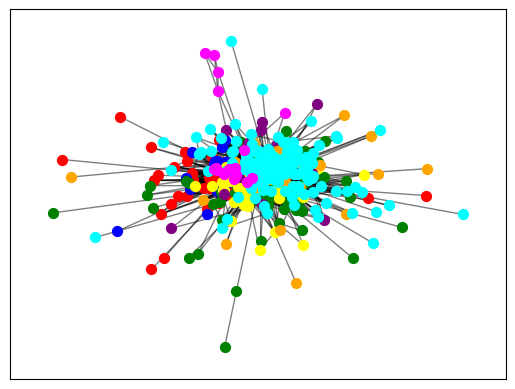

Cluster information table:


,Cluster ID,Number of Nodes,total_weight,nodes,group_names,attendance_percentages
0,0,75,23169,"[19292162, 535553, 18850080, 6707902, 4126912,...","[Nashville CocoaHeads, Nash.rb, NashReact, Dat...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
1,1,27,8287,"[20947040, 9376702, 1360698, 18361585, 1660782...","[Nashville Blockchain Meetup, Nashville Women ...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
2,2,87,13732,"[19997487, 19194894, 11294262, 19828207, 11184...","[Developer Launchpad Nashville, Nashville Chri...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
3,3,33,4517,"[19277993, 11625832, 1457232, 16321082, 188371...","[Nashville DevOps Meetup, PyNash, Volunteer Na...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
4,4,26,2477,"[19218850, 18414590, 19964997, 18556100, 18288...","[Greater Nashville Healthcare Analytics, Women...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
5,5,43,8483,"[1179719, 18506072, 20807142, 13560402, 981249...","[Nashvegans!, 20s in Nashville, Music City You...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
6,6,148,30872,"[19728145, 18297014, 339011, 24925734, 1895583...","[Stepping Out Social Dance Meetup, Nashville C...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
7,7,17,4834,"[1728035, 541319, 1358081, 1433893, 11626822, ...","[WordPress Nashville, The Nashville Songwriter...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."


Top 3 groups is respective cluster


,Cluster ID,top_groups
0,0,[(iProduce BNA - Pro iPhone / iPad camera / RE...
1,1,"[(Skeleton Cru,), (Serial Tanks Meetup,), (Pad..."
2,2,"[(Women's Business Network,), (Women of Power..."
3,3,"[(Volunteer Nashville,), (Unity of Nashville S..."
4,4,"[(Women, Wine, & Coloring,), (Women'n'Wine of ..."
5,5,"[(the New World is in Order!,), (WomanSpeak, N..."
6,6,"[(¡Diablos Que Bailan! (Salsa Nashville),), (Y..."
7,7,"[(WordPress Nashville,), (The Nashville Web De..."


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from datetime import datetime
from IPython.display import display

# Load the datasets
group_edges = pd.read_csv('group-edges.csv')
meta_events = pd.read_csv('meta-events.csv')
member_to_group_edges = pd.read_csv('member-to-group-edges.csv')
meta_groups = pd.read_csv('meta-groups.csv')
rsvps = pd.read_csv('rsvps.csv')

# Conversion of timestamp into datetime format
meta_events['time'] = pd.to_datetime(meta_events['time'])

# Merging meta_groups and meta_events
meta_events = meta_events.merge(meta_groups, on='group_id')


# Calculate the #number of members for each group
#it is possible that a member can be present in multiple groups
total_members = member_to_group_edges.groupby('group_id')['member_id'].nunique()

# Function to create a graph based on events up to a specific date
def create_graph_on_date(date):
    # Filter events up to the given date
    events_upto_date = meta_events[meta_events['time'] <= date]

    # The `rsvps_upto_date`: flitered data set to include only events that occurred on or before specified date
    # Further this filtered data set will be merge with meta_events and member_to_group_edges and then
    # This data set is then used to create the graph of group relationships.
    rsvps_upto_date = rsvps.merge(events_upto_date, on='event_id')
    rsvps_upto_date = rsvps_upto_date.merge(member_to_group_edges[['member_id', 'group_id']], on='member_id')
    


    # Group by member and group IDs, and aggregate by counting the number of events attended in each group
    member_to_group_edges_upto_date = rsvps_upto_date.groupby(['member_id', 'group_id']).size().reset_index(name='weight')

    # Merging filtered member-to-group edges and group_edges
    group_edges_upto_date = group_edges.merge(member_to_group_edges_upto_date, left_on='group1', right_on='group_id')
    group_edges_upto_date = group_edges_upto_date.merge(member_to_group_edges_upto_date, left_on=['group2', 'member_id'], right_on=['group_id', 'member_id'])
    

    # Create the graph from the filtered group_edges_upto_date
    G = nx.from_pandas_edgelist(group_edges_upto_date, source='group1', target='group2', edge_attr='weight')

    return G, member_to_group_edges_upto_date, rsvps_upto_date


# Define the cluster_info function
def cluster_info(G, partition, rsvps_upto_date, total_members):
    #dictionary to store cluster information
    cluster_summary = {}

    for node, cluster_id in partition.items():
        if cluster_id not in cluster_summary:
            cluster_summary[cluster_id] = {'nodes': [], 'total_weight': 0}
        cluster_summary[cluster_id]['nodes'].append(node)

    # Iterate over the cluster_summary dictionary to calculate the total weight of the edges within each cluster. 
    # Update the total_weight value in the cluster_summary dictionary.
    for cluster_id, info in cluster_summary.items():
        total_weight = 0
        for node1 in info['nodes']:
            for node2 in info['nodes']:
                if G.has_edge(node1, node2):
                    total_weight += G[node1][node2]['weight'] # fpr ed
        cluster_summary[cluster_id]['total_weight'] = total_weight // 2

    cluster_df = pd.DataFrame.from_dict(cluster_summary, orient='index') #Create a DataFrame cluster_df from the cluster_summary dictionary with clusters as index.
    cluster_df.index.name = 'Cluster ID'
    cluster_df.reset_index(inplace=True)
    #lambda function: takes input of nodes list and returns value of lenght of list 
    cluster_df['Number of Nodes'] = cluster_df['nodes'].apply(lambda x: len(x)) #apply() is a method of a pandas DataFrame that allows you to apply a function to each row or column of the DataFrame.

    #group names and attendance percentages adding to the cluster
    cluster_df['group_names'] = cluster_df['nodes'].apply(lambda nodes: [meta_groups.loc[meta_groups['group_id'] == node, 'group_name'].values[0] for node in nodes])
    total_members_dict = total_members.to_dict() #Convert the total_members DataFrame into a dictionary.
    cluster_df['attendance_percentages'] = cluster_df['nodes'].apply(lambda nodes: [calculate_attendance_percentage(node, rsvps_upto_date, total_members_dict) for node in nodes])

    return cluster_df[['Cluster ID', 'Number of Nodes', 'total_weight', 'nodes', 'group_names', 'attendance_percentages']]

# Select the time points at which you want to analyze the community evolution
time_points = pd.date_range(meta_events['time'].min(), meta_events['time'].max(), periods=3)

def get_top_groups(row, n=3):
    combined = list(zip(row['group_names']))
    combined.sort(key=lambda x: x[0], reverse=True)
    return combined[:n]

# Function to calculate the percentage of group members who attended the meeting for each group
def calculate_attendance_percentage(group_id, rsvps_upto_date, total_members):
    attended_members = rsvps_upto_date[rsvps_upto_date['group_id'] == group_id]['member_id'].nunique()
    return (attended_members / total_members[group_id]) * 100

# Analyze community evolution at the selected time points
for time_point in time_points:
    print(f"Community evolution on {time_point.strftime('%Y-%m-%d')}:")
    G, member_to_group_edges_upto_date, rsvps_upto_date = create_graph_on_date(time_point) #unpack the tuple
    partition = community_louvain.best_partition(G)

    # Plot the community structure at this particular time point
    pos = nx.spring_layout(G, seed=42)
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'pink', 'grey']
    num_clusters = len(set(partition.values()))
    for cluster_id in range(num_clusters):
        node_list = [node for node, membership in partition.items() if membership == cluster_id] #This line creates a list of nodes that belong to the current cluster being iterated over. 
        nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=colors[cluster_id], node_size=50)
        # nx.draw_networkx_labels(G, pos, labels={node: node for node in node_list}, font_size=8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

    # Cluster information table
    cluster_df = cluster_info(G, partition, rsvps_upto_date, total_members)
    print("Cluster information table:")
    display(cluster_df)
    cluster_df['top_groups'] = cluster_df.apply(get_top_groups, axis=1)
    top_groups_df = cluster_df[['Cluster ID', 'top_groups']]

    # Displaying top_group
    print("Top 3 groups is respective cluster")
    display(top_groups_df)
    # -----------------------------------------------------------------------------

    print("\n")
    
    



BELOW TEMPORAL NETWORK ANALYSIS WRITTEN BY NIHAR 

In [ ]:
# load data
events_df = pd.read_csv('meta-events.csv')
edges_df = pd.read_csv('member-to-group-edges.csv')

# convert time column to datetime format
events_df['time'] = pd.to_datetime(events_df['time'], format='%Y/%m/%d %H:%M:%S')

# create table of total events per month
events_df['year_month'] = events_df['time'].dt.to_period('M')
events_count_month = events_df.groupby('year_month')['event_id'].count().reset_index()
events_count_month.rename(columns={'event_id': 'total_events'}, inplace=True)

# create table of unique members per month
edges_df['year_month'] = pd.to_datetime(events_df['time'], format='%Y/%m/%d %H:%M:%S').dt.to_period('M')
unique_members_month = edges_df.groupby('year_month')['member_id'].nunique().reset_index()
unique_members_month.rename(columns={'member_id': 'unique_members'}, inplace=True)

# convert year_month column to string format
analysis_df['year_month_str'] = analysis_df['year_month'].dt.strftime('%Y-%m')

# plot graph of total events and unique members per month
plt.figure(figsize=(10, 6))
plt.plot(analysis_df['year_month_str'], analysis_df['total_events'], label='Total events')
plt.plot(analysis_df['year_month_str'], analysis_df['unique_members'], label='Unique members')
plt.xticks(rotation=45)
plt.title('Temporal analysis of events and members')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.legend()
plt.show()

# print tables for better clarification
print('Total events per month:')
print(events_count_month.to_string(index=False))

print('\nUnique members per month:')
print(unique_members_month.to_string(index=False))

print('\nAnalysis table:')
print(analysis_df.to_string(index=False))

In [ ]:
# Load data
rsvps = pd.read_csv('rsvps.csv')
meta_events = pd.read_csv('meta-events.csv')

# Convert the timestamp column to a datetime object and filter events for December 2015
meta_events['time'] = pd.to_datetime(meta_events['time'])
december_2015_events = meta_events[(meta_events['time'].dt.year == 2015) & (meta_events['time'].dt.month == 12)]

# Merge the December 2015 events with the RSVPs data
rsvps_december_2015 = rsvps[rsvps['event_id'].isin(december_2015_events['event_id'])]

# Calculate the number of attendees for each event
event_attendees = rsvps_december_2015.groupby('event_id')['member_id'].nunique().reset_index()
event_attendees.columns = ['event_id', 'num_attendees']

# Merge the number of attendees with event metadata and sort by the number of attendees in ascending order
least_popular_events = december_2015_events.merge(event_attendees, on='event_id').sort_values('num_attendees')

# Display the resulting table
least_popular_events[['event_id', 'name', 'time', 'num_attendees']]

In [ ]:
# Read in the data
group_edges = pd.read_csv('group-edges.csv')
member_edges = pd.read_csv('member-edges.csv')
member_group_edges = pd.read_csv('member-to-group-edges.csv')
meta_groups = pd.read_csv('meta-groups.csv', index_col='group_id')
meta_members = pd.read_csv('meta-members.csv', index_col='member_id')
meta_events = pd.read_csv('meta-events.csv', index_col='event_id')
rsvps = pd.read_csv('rsvps.csv')

# Create member-to-group bipartite graph
G_mb = nx.Graph()
for i, row in member_group_edges.iterrows():
    G_mb.add_edge(row['member_id'], row['group_id'], weight=row['weight'])

# Create group-to-group graph
G_gg = nx.Graph()
for i, row in group_edges.iterrows():
    G_gg.add_edge(row['group1'], row['group2'], weight=row['weight'])

# Create member-to-member graph
G_mm = nx.Graph()
for i, row in member_edges.iterrows():
    G_mm.add_edge(row['member1'], row['member2'], weight=row['weight'])

    
#This part of the code loads the meta-events.csv file and performs a longitudinal analysis on the number of events per month.
import pandas as pd
import matplotlib.pyplot as plt

# Load the meta-events.csv file
df_events = pd.read_csv("meta-events.csv")

# Convert the time column to a datetime object
df_events["time"] = pd.to_datetime(df_events["time"])

# Group the events by year and month
df_events["year_month"] = df_events["time"].apply(lambda x: f"{x.year}-{x.month:02}")
df_events_grouped = df_events.groupby("year_month").size().reset_index(name="count")
#creates a new column year_month in the df_events DataFrame using a 
#lambda function that extracts the year and month from the time column and formats it as a string in the form "YYYY-MM".
#The groupby method is used to group the events by year_month, and the size method is used to count the number of events in each group. 
# The reset_index method is used to convert the resulting grouped Series back to a DataFrame and reset the index. 
# The resulting DataFrame is stored in the variable df_events_grouped

# Plot the graph of number of events per month
plt.plot(df_events_grouped["year_month"], df_events_grouped["count"])
plt.xticks(rotation=90)
plt.xlabel("Year-Month")
plt.ylabel("Number of Events")
plt.title("Longitudinal Analysis of Number of Events")
plt.show()
#create a line plot of the number of events per month using plt.plot.
# The x-axis values are the year_month column of the df_events_grouped DataFrame, and the y-axis values are the count column. 
# The plt.xticks function rotates the x-axis tick labels by 90 degrees to avoid overlapping. 
# The plt.xlabel, plt.ylabel, and plt.title functions set the axis labels and title of the plot. The plt.show function displays the plot.